In [1]:
import os
import torch
import datasets.paths as d_path
import torchvision

from utils.init import reproducibility, clean_memory_get_device
from config import ConfigArgs
from utils.train import EarlyStopper, TrainingInfo, epoch_end_print, get_dataloaders, get_datasets, check_best, end_train, evaluate, train_one_epoch
from torchvision.models import resnet18, ResNet18_Weights
from utils.plot import plot_losses
from IPython.display import clear_output
from datasets.reflacx.chexpert import REFLACXCheXpertDataset
from datasets.reflacx.lesion_detection import REFLACXLesionDetectionDataset
from engine.classification import ClassificationEvaluator, load_cl_pretrained, resnet_set_trainable_layers
from models.classification import MultiBinaryClassificationModel

import warnings
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
device = clean_memory_get_device()
# device = torch.device("cpu")
reproducibility()
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())

This notebook will running on device: [CUDA]
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large 

In [3]:
from config.dataset import REFLACXCheXpertDatasetArgs
from config.model import ResNetClassifierArgs
from config.training import ImageClassificationArgs

training_args = ImageClassificationArgs(
    name="chexpert",
)
dataset_args = REFLACXCheXpertDatasetArgs(
    image_size=128,
)
cl_model_name = "MCL_resnet50_accuracy_0_1433_epoch48_10-08-2023 15-58-25"


configs = [
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=ResNetClassifierArgs(
    #         name="CL_NoFix",
    #         weights="cl",
    #         cl_model_name=cl_model_name,
    #         trainable_backbone_layers=5,
    #         release_fixed_weights_after=2,
    #     )
    # ),
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=ResNetClassifierArgs(
    #         name="CL_Fix5Layers",
    #         weights="cl",
    #         cl_model_name=cl_model_name,
    #         trainable_backbone_layers=0,
    #     ),
    # ),
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=ResNetClassifierArgs(
    #         name="CL_Fix2Layers",
    #         weights="cl",
    #         cl_model_name=cl_model_name,
    #         trainable_backbone_layers=3,
    #     )
    # ),
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=ResNetClassifierArgs(
    #         name="CL_Fix20Epoch",
    #         weights="cl",
    #         cl_model_name=cl_model_name,
    #         trainable_backbone_layers=0,
    #         release_fixed_weights_after=20,
    #     ),
    # ),
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=ResNetClassifierArgs(
    #         name="ImageNet_Fix2Layers",
    #         weights="imagenet",
    #         trainable_backbone_layers=3,
    #     )
    # ),
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=ResNetClassifierArgs(
    #         name="ImageNet_Fix5layers",
    #         weights="imagenet",
    #         trainable_backbone_layers=0,
    #     )
    # ),
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=ResNetClassifierArgs(
    #         name="ImageNet_Fix2Layers",
    #         weights="imagenet",
    #         trainable_backbone_layers=3,
    #     )
    # ),
    ConfigArgs(
        training=training_args,
        dataset=dataset_args,
        model=ResNetClassifierArgs(
            name="ImageNet_Fix20Epoch",
            weights="imagenet",
            trainable_backbone_layers=0,
            release_fixed_weights_after=20,
        ),
    ),
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=ResNetClassifierArgs(
    #         name="ImageNet_NoFix",
    #         weights="imagenet",
    #         trainable_backbone_layers=5,
    #     )
    # ),
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=ResNetClassifierArgs(
    #         name="Random",
    #         weights=None,
    #         trainable_backbone_layers=5,
    #     )
    # ),
]

In [4]:
num_epochs = 100 # 200
train_infos: list[TrainingInfo] = []

In [5]:
# model, optimiser = set_weights_trainable(model, optimiser, "backbone")
# for n, p in  model.named_parameters():
#     if p.requires_grad:
#         print(n)

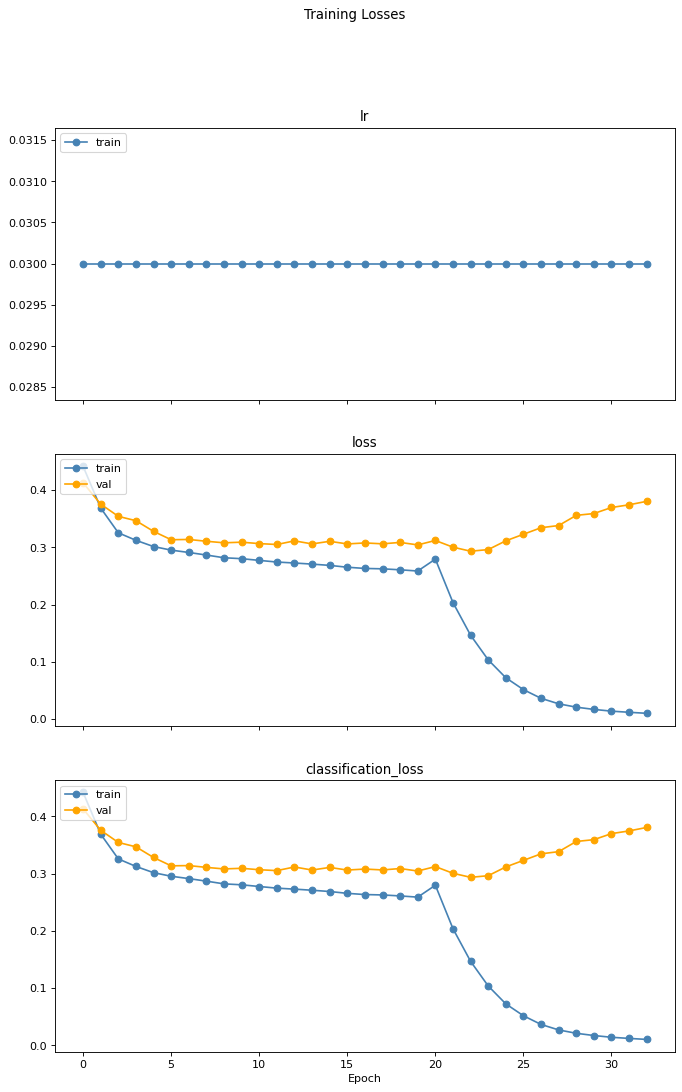

| Epoch [33] Done | It has took [58.03] min, Avg time: [105.51] sec/epoch | Estimate time for [100] epochs: [175.84] min | Epoch took [104.953069] sec |  Patience [9] |
| Patience reached [10], EarlyStopping end |
| Training Done, start testing! | [33] Epochs Training time: [3481.723476] seconds, Avg time / Epoch: [105.506772] seconds
========================================For Training [chexpert - ImageNet_Fix20Epoch]========================================
ImageClassificationArgs(name='chexpert', learning_rate=0.03, sgd_momentum=0.9, batch_size=128, weight_decay=0.0001, early_stopping_patience=10, warmup_epoch=0)
REFLACXCheXpertDatasetArgs(image_size=128, label_cols=['Atelectasis_chexpert', 'Cardiomegaly_chexpert', 'Consolidation_chexpert', 'Edema_chexpert', 'Enlarged Cardiomediastinum_chexpert', 'Fracture_chexpert', 'Lung Lesion_chexpert', 'Lung Opacity_chexpert', 'No Finding_chexpert', 'Pleural Effusion_chexpert', 'Pleural Other_chexpert', 'Pneumonia_chexpert', 'Pneumothorax_chexpe

In [6]:
from engine.classification import load_backbone
from utils.train import set_weights_trainable


for config in configs:
    # device = clean_memory_get_device()
    # reproducibility()

    train_info = TrainingInfo(config)

    model = MultiBinaryClassificationModel(None)
    backbone = load_backbone(config, device)
    model.backbone = backbone
    model.setup_last_layer(len(config.dataset.label_cols))
    model.to(device)

    dataset_args = {
        "df_path": os.path.join('spreadsheets', "reflacx.csv"),
        "mimic_eye_path": d_path.MIMIC_EYE_PATH,
        "image_size": config.dataset.image_size,
        "label_cols": config.dataset.label_cols,
    }

    train_dataset, val_dataset, _ = get_datasets(
        dataset_args=dataset_args,
        dataset_class=REFLACXCheXpertDataset,
    )

    train_dataloader, val_dataloader = get_dataloaders(
        train_dataset,
        val_dataset,
        batch_size=config.training.batch_size,
        drop_last=False,
    )

    optimiser = torch.optim.SGD(
        params=[p for p in model.parameters() if p.requires_grad],
        lr=config.training.learning_rate,
        momentum=config.training.sgd_momentum,
        weight_decay=config.training.weight_decay,
    )

    early_stopper = None
    if config.training.early_stopping_patience:
        early_stopper = EarlyStopper(
            patience=config.training.early_stopping_patience)

    train_info.timer.start_training()

    for e in range(1, num_epochs + 1):
        train_info.epoch = e
        train_info.timer.start_epoch()
        for t_i in train_infos:
            print(t_i)
        print(train_info)

        # release fixed weights.
        if (not config.model.release_fixed_weights_after is None) and (e > config.model.release_fixed_weights_after):
            model, optimiser = set_weights_trainable(model, optimiser, "backbone")

        train_logger = train_one_epoch(
            model=model,
            optimiser=optimiser,
            data_loader=train_dataloader,
            device=device,
            epoch=train_info.epoch,
            print_freq=10,
        )

        train_info.train_losses.append(train_logger.get_data())

        model.eval()

        val_logger, val_evaluator = evaluate(
            model=model,
            data_loader=val_dataloader,
            device=device,
            evaluator=ClassificationEvaluator(),
        )

        train_info.val_losses.append(val_logger.get_data())

        clear_output()
        plot_losses(
            train_info.train_losses,
            train_info.val_losses,
        )
        epoch_end_print(train_info, early_stopper, num_epochs)

        if early_stopper and train_info.epoch > config.training.warmup_epoch:
            train_info = check_best(
                train_info=train_info,
                model=model,
                optimiser=optimiser,
                val_evaluator=val_evaluator,
            )
            to_stop = early_stopper.early_stop(
                train_info.val_losses[-1]['loss'])
            if to_stop:
                print(
                    f"| Patience reached [{early_stopper.counter}], EarlyStopping end |")
                break

    train_info = end_train(
        train_info=train_info,
        model=model,
        optimiser=optimiser,
        val_evaluator=val_evaluator,
    )

    train_infos.append(train_info)

========================================For Training [chexpert - ImageNet_Fix20Epoch]========================================
ImageClassificationArgs(name='chexpert', learning_rate=0.03, sgd_momentum=0.9, batch_size=128, weight_decay=0.0001, early_stopping_patience=10, warmup_epoch=0)
REFLACXCheXpertDatasetArgs(image_size=128, label_cols=['Atelectasis_chexpert', 'Cardiomegaly_chexpert', 'Consolidation_chexpert', 'Edema_chexpert', 'Enlarged Cardiomediastinum_chexpert', 'Fracture_chexpert', 'Lung Lesion_chexpert', 'Lung Opacity_chexpert', 'No Finding_chexpert', 'Pleural Effusion_chexpert', 'Pleural Other_chexpert', 'Pneumonia_chexpert', 'Pneumothorax_chexpert', 'Support Devices_chexpert'])
ResNetClassifierArgs(name='ImageNet_Fix20Epoch', weights='imagenet', cl_model_name=None, trainable_backbone_layers=0, release_fixed_weights_after=20)

Best model has been saved to: [chexpert_ImageNet_Fix20Epoch_f1_0_4876_precision_0_6879_accuracy_0_8895_recall_0_3777_auc_0_6750_epoch23_10-17-2023 03-11

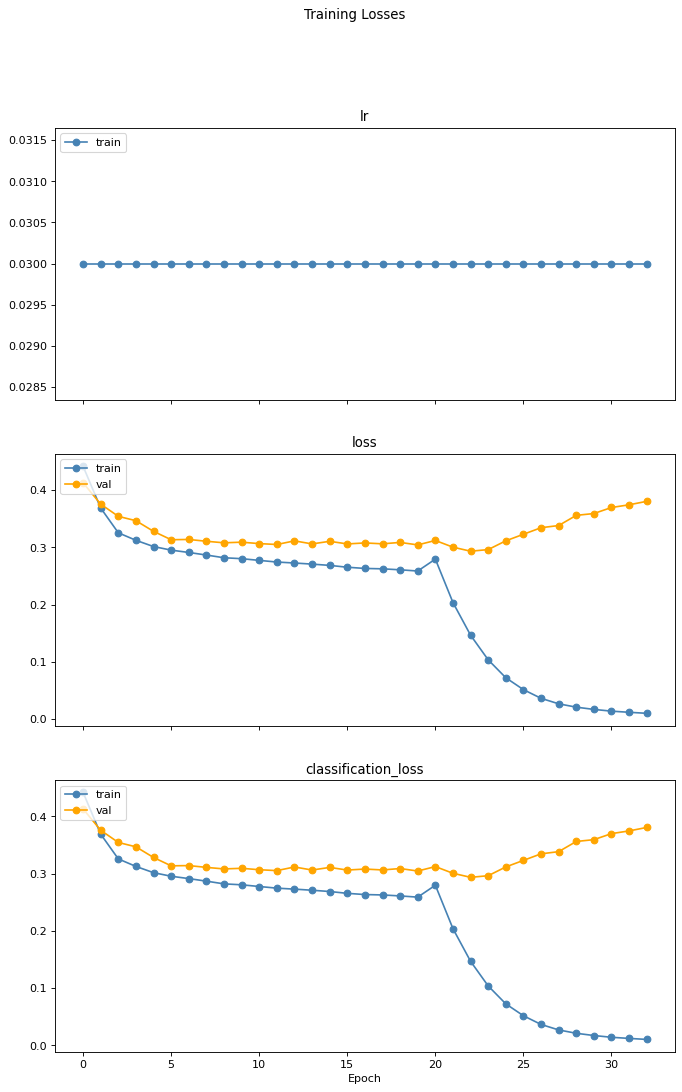

In [7]:
for t in train_infos :
    print(t)
    plot_losses(
        t.train_losses,
        t.val_losses,
    )

In [8]:
# Evaluate all train_infos on the best
from utils.checkpoint import load_checkpoints

performances = {}

for t in train_infos:

    train_info, cp = load_checkpoints(t.best_val_loss_model_path, device)
    config = train_info.config

    backbone = resnet18(weights=None)
    model = MultiBinaryClassificationModel(backbone)
    model.setup_last_layer(len(config.dataset.label_cols))
    model.to(device)
    model.load_state_dict(cp["model"])
    model.eval()

    dataset_args = {
        "df_path": os.path.join('spreadsheets', "reflacx.csv"),
        "mimic_eye_path": d_path.MIMIC_EYE_PATH,
        "image_size": config.dataset.image_size,
        "label_cols": config.dataset.label_cols,
    }

    _, _, test_dataset = get_datasets(
        dataset_args=dataset_args,
        dataset_class=REFLACXCheXpertDataset,
    )

    _, _, test_dataloader = get_dataloaders(
        train_dataset,
        val_dataset,
        test_dataset,
        batch_size=config.training.batch_size,
        drop_last=False,
    )

    _, test_evaluator = evaluate(
            model=model,
            data_loader=test_dataloader,
            device=device,
            evaluator=ClassificationEvaluator(),
        )
    
    
    print(t)
    print(test_evaluator.get_performance())
    performances[f"{config.training.name} - {config.model.name}"] = test_evaluator.get_performance()

    with open(os.path.join('checkpoints',t.best_val_loss_model_path, 'performance.txt'), 'w') as f:
        f.write(str(t) +"\n"+ "Best: \n" +str(test_evaluator.get_performance()))

Test:  [0/4]  eta: 0:00:32  model_time: 0.1795 (0.1795)  evaluator_time: 0.0000 (0.0000)  loss: 0.3016 (0.3016)  classification_loss: 0.3016 (0.3016)  time: 8.1477  data: 7.9407  max mem: 1038
Test:  [3/4]  eta: 0:00:07  model_time: 0.1035 (0.1300)  evaluator_time: 0.0000 (0.0000)  loss: 0.2531 (0.2748)  classification_loss: 0.2531 (0.2748)  time: 7.2650  data: 7.1121  max mem: 1038
Test: Total time: 0:00:29 (7.2650 s / it)
Averaged stats: model_time: 0.1035 (0.1300)  evaluator_time: 0.0000 (0.0000)  loss: 0.2531 (0.2748)  classification_loss: 0.2531 (0.2748)
========================================For Training [chexpert - ImageNet_Fix20Epoch]========================================
ImageClassificationArgs(name='chexpert', learning_rate=0.03, sgd_momentum=0.9, batch_size=128, weight_decay=0.0001, early_stopping_patience=10, warmup_epoch=0)
REFLACXCheXpertDatasetArgs(image_size=128, label_cols=['Atelectasis_chexpert', 'Cardiomegaly_chexpert', 'Consolidation_chexpert', 'Edema_chexpert', 

In [9]:
pd.DataFrame(performances)

,chexpert - ImageNet_Fix20Epoch
accuracy,0.891680
auc,0.674187
f1,0.486607
precision,0.694268
recall,0.374570


In [10]:
p_df = pd.DataFrame(performances).transpose()

In [11]:
p_df[["f1", "precision", "accuracy", "recall", "auc"]]

,f1,precision,accuracy,recall,auc
chexpert - ImageNet_Fix20Epoch,0.486607,0.694268,0.89168,0.37457,0.674187
